## Dataset for store-specific infromation

In this notebook, we take a first look at the data in `store.csv` and carry out pre-processing where we consider it to be necessary.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's first look at the data from the `store.csv` file:

In [2]:
stores_df = pd.read_csv('../data/store.csv')
stores_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Meaning of the variables:  
- Store: A unique ID for each store.
- StoreType: Distinguishes between four different store models (a, b, c, d).
- Assortment: Describes an assortment level (a = basic, b = extra, c = extended).
- CompetitionDistance: Is the distance in meters to the nearest competitor store.
- CompetitionOpenSince[Month/Year]: Indicates the approximate year and month of the next competitor's opening.
- Promo2: Is a consecutive and consecutive promotion for some stores (0 = store does not participate, 1 = store participates).
- Promo2Since[Week/Year]: Describes the year and calendar week in which the store started to participate in Promo2
- PromoInterval: Describes the consecutive intervals in which Promo2 is started by naming the months in which the promotions are restarted. For example, “Feb, May, Aug, Nov” means that each round starts in February, May, August, November of each year for this store.

The variables `CompetitionDistance`, `CompetitionOpenSince[Month/Year]`, `CompetitionOpenSince[Month/Year]`  
`Promo2Since[Week/Year]`, and `PromoInterval` have missing values.

##### Data preprocessing
First, let's look at the descriptive statistics for this data set:

In [4]:
stores_df.drop('Store', axis=1).describe()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


##### CompetitionDistance  
What do the branches look like for which there is no value for the variable `CompetitionDistance`?

In [5]:
stores_df[stores_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


What does the distribution of CompetitionDistance look like?

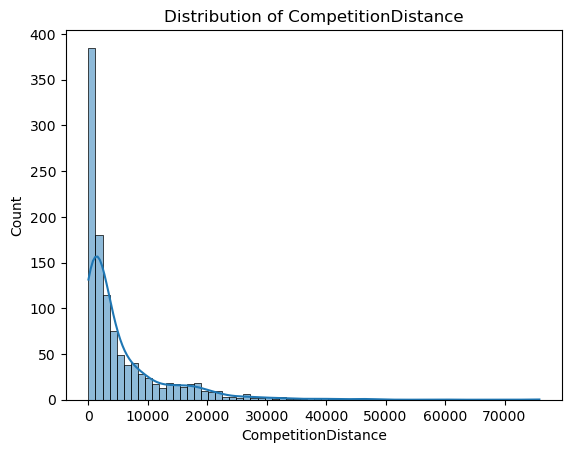

In [5]:
sns.histplot(stores_df['CompetitionDistance'], kde=True).set(title="Distribution of CompetitionDistance");

Is there a correlation between the distance of competitors and the store type or assortment?

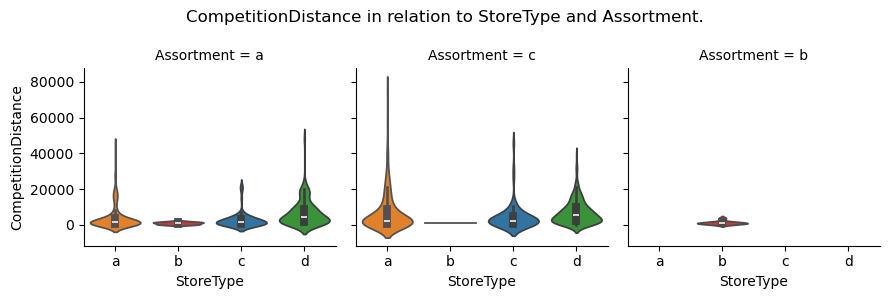

In [6]:
g=sns.FacetGrid(stores_df, col='Assortment', margin_titles=True, hue='StoreType')
g.map(sns.violinplot, 'StoreType', 'CompetitionDistance', order=['a', 'b', 'c', 'd'])
g.fig.suptitle('CompetitionDistance in relation to StoreType and Assortment.')
plt.tight_layout();

Since the distribution of CompetitionDistance is skewed, I will replace its missing values with the median in the corresponding (Assortment, StoreType) groups in the hope of introducing as little bias as possible:

In [7]:
stores_by_type_assort = stores_df.groupby(['StoreType', 'Assortment'])

stores_df['CompetitionDistance'] = stores_df['CompetitionDistance'].fillna(
    stores_by_type_assort['CompetitionDistance'].transform('median'))

stores_df['CompetitionDistance'].isna().sum()

0

##### CompetitionOpenSince[Month/Year]

First we merge `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` into a new column called `CompetitionOpenSince` of type datetime and then remove the original columns.

In [8]:
# help function to combine year and month to a datetime
def year_month_to_datetime(year_month):
    year = year_month.iloc[0]
    month = year_month.iloc[1]
    try:
        date = '{}-{}'.format(int(year), int(month))
        return pd.to_datetime(date)
    except:
        return np.nan

In [9]:
stores_df['CompetitionOpenSince'] = stores_df[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].apply(year_month_to_datetime, axis=1)
stores_df.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], axis=1, inplace= True)

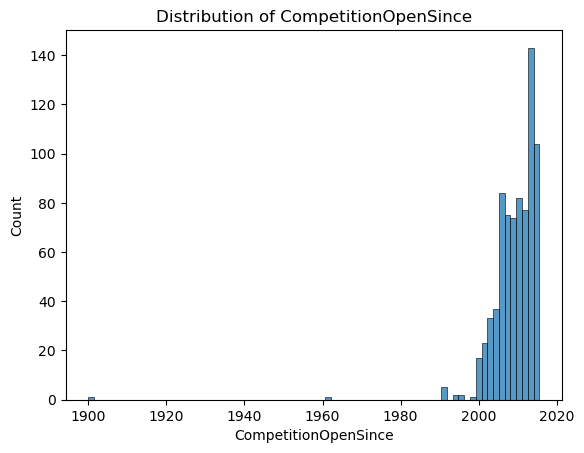

In [10]:
sns.histplot(data=stores_df, x='CompetitionOpenSince').set(title='Distribution of CompetitionOpenSince');

We note that the distribution of CompetitionOpenSince is asymmetrical and that there are outliers. We will only impute the missing values once the store data and the sales data have been merged.

##### Variables that are related to Promo2

There is no store with `Promo2` equal to 1 for which there is no value for `Promo2Since[Week\Year]`, or `PromoInterval`:

In [11]:
promo2_mask = stores_df['Promo2'] == 1
stores_df[promo2_mask][['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].isnull().sum()

Promo2SinceWeek    0
Promo2SinceYear    0
PromoInterval      0
dtype: int64

Similar to `CompetitionOpenSince[Month/Year]`, we encode `Promo2Since[Week/Year]` in a single `Promo2Since` variable of type datetime.

In [12]:
from datetime import datetime

# help function to combine week and year to a datetime
def week_year_to_datetime(week_year):
    week = week_year.iloc[0]
    year = week_year.iloc[1]
    try:
        # Monday of the corresponding week
        date = datetime.strptime('{}-{}-1'.format(int(year), int(week)), "%Y-%W-%w")
        return pd.to_datetime(date)
    except:
        return np.nan

In [13]:
stores_df['Promo2Since'] = stores_df[['Promo2SinceWeek', 'Promo2SinceYear']].apply(week_year_to_datetime, axis=1)
stores_df.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis=1, inplace= True)

Let's look at the possible values of `PromoInterval`:

In [15]:
stores_df['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

Wie wir sehen, hat Promo2 einen vierteljährlichen Rhythmus, der entweder im Januar, Februar oder März beginnen kann.

We change the order of the columns and save the result as a CSV file.

In [14]:
stores_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',
       'PromoInterval', 'CompetitionOpenSince', 'Promo2Since'],
      dtype='object')

In [15]:
stores_df = stores_df[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSince',
                       'Promo2', 'Promo2Since', 'PromoInterval']]

stores_df.to_csv("../data/stores_clean.csv", index=False)
pd.read_csv("../data/stores_clean.csv")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSince,Promo2,Promo2Since,PromoInterval
0,1,c,a,1270.0,2008-09-01,0,NaN,NaN
1,2,a,a,570.0,2007-11-01,1,2010-03-29,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,2006-12-01,1,2011-04-04,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,2009-09-01,0,NaN,NaN
4,5,a,a,29910.0,2015-04-01,0,NaN,NaN
...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,2014-06-01,1,2013-08-05,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,2006-04-01,0,NaN,NaN
1112,1113,a,c,9260.0,NaN,0,NaN,NaN
1113,1114,a,c,870.0,NaN,0,NaN,NaN
